### В проекте предстоит поработать аналитиком данных в компании «Карпов Саунд», которая занимается оптовой продажей аудиотехники и предлагает широкий ассортимент товаров от ведущих мировых брендов, включающий профессиональные аудиосистемы, домашние кинотеатры, портативные аудиоустройства и прочие аксессуары.

«Карпов Саунд» сотрудничает с крупными розничными сетями и специализированными магазинами аудиотехники в России. Клиенты компании регулярно оставляют заявки на закупку товаров в CRM системе, менеджеры связываются с клиентами, обсуждают детали, после чего заказы либо подтверждаются менеджерами, либо по разным причинам отменяются. 

В «Карпов Саунд» трепетно относятся к хранению информации о своих товарах, клиентах и заказах, однако в самый неподходящий момент хранилище данных компании оказалось временно недоступно из-за плановых работ по его оптимизации. Поэтому в рамках этого проекта все данные будут представлены не в самом удобном для анализа виде — в формате резервной выгрузки, разложенной по разным папкам на сервере компании.

Необходимо собрать данные из разрозненных источников, проанализировать их и сделать выводы, которые помогут руководству компании принять верные тактические решения.

## Шаг 1


**В ходе работы над проектом встретятся следующие таблицы:**  

1) orders (данные о заказах):  
- order_id — номер заказа  
- product_id — идентификатор товара  
- quantity — количество этого товара в заказе

2) order_status (данные о статусах заказов и клиентах):
- order_id — номер заказа  
- client_id — идентификатор клиента  
- status — статус заказа

3) products (данные о товарах):
- id — идентификатор товара  
- name — имя товара (сначала указан бренд, через запятую модель товара)  
- price — цена единицы товара, в долларах

Каждый заказ имеет статус или подтвержденного (`confirmed`), или отмененного (`canceled`). В одном заказе может быть несколько разных товаров. Если заказ был отменен, а потом создан такой же (тем же клиентом, с теми же товарами, у того же менеджера), в базе останется запись о двух заказах с разными номерами и статусами, поскольку система не позволяет создать заказ с тем же номером.

Сначала нужно собрать и предобработать три типа датасетов: `orders.csv`, `order_status.csv`, `products.csv`.

На схеме показано, как связаны таблицы между собой:

![](https://storage.yandexcloud.net/klms-public/production/learning-content/457/4167/37264/104636/497986/er_white.png)

Данные находятся в папке `data`. Внутри папки `data` находятся 2 другие папки: `orders` и `products`.

В папке `orders` папки с датами, в которые сделаны записи. В этих папках — папки с именами менеджеров по продажам. Эти папки содержат файлы `orders.csv` и `order_status.csv` (в каждой папке по одной паре файлов). Пример структуры: `data` -> `orders` -> `2024-03-01` -> `Алексей Саксофонов` -> `orders.csv` и `order_status.csv`.

В папке `products` папки с категориями товаров. В этих папках файлы `products.csv` (в каждой папке по одному файлу). Пример структуры: `data` -> `products` -> `AV-процессор` -> `products.csv`.

Кроме того есть файл `usd_rate.txt` с курсом доллара США на каждый день анализируемого периода (данные в формате `дата,курс,валюта`). Он потребуется в середине проекта.

### Соберем датасет с заказами по папкам

## Шаг 2

**Первая задача — собрать данные со всех папок в три датафрейма:**  
1. `df_orders` — на основе датасетов `orders.csv` + добавьте колонку `manager` с именами менеджеров и колонку `date` с датами. Отсортируйте датафрейм по возрастанию `order_id` и `product_id`.
2. `df_order_status` — на основе датасетов `order_status.csv`. Отсортируйте датафрейм по возрастанию `order_id`. 
3. `df_products` — на основе датасетов `products.csv` + добавьте колонку `category` с категориями товаров. Отсортируйте датафрейм по возрастанию `id`.  

**Соберите датафреймы и сохраните их в соответствующие csv файлы: `df_orders.csv`, `df_order_status.csv` и `df_products.csv`. Отправьте файлы на проверку в LMS.**

In [80]:
# Ваш код здесь
import os
import pandas as pd

way = "./data"
file_paths = []

for path, dirs, files in os.walk(way):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(path, file)
            file_paths.append(file_path)

print(file_paths[:5])

['./data\\orders\\2024-03-01\\Алексей Саксофонов\\orders.csv', './data\\orders\\2024-03-01\\Алексей Саксофонов\\order_status.csv', './data\\orders\\2024-03-01\\Аркадий Октавин\\orders.csv', './data\\orders\\2024-03-01\\Аркадий Октавин\\order_status.csv', './data\\orders\\2024-03-01\\Виктор Тромбонов\\orders.csv']


In [79]:
df_orders = pd.DataFrame()
df_order_status = pd.DataFrame()
df_products = pd.DataFrame()

for path in file_paths:
    data = pd.read_csv(path)
    if path.endswith('orders.csv'):
        parsed = path.split(os.sep)

        name = parsed[-2]
        date = parsed[-3]

        data['manager'] = name
        data['date'] = date
        
        df_orders = pd.concat([df_orders, data])
    
    elif path.endswith('products.csv'): 
        parsed = path.split(os.sep)
        category = parsed[-2] 

        data['category'] = category
        df_products = pd.concat([df_products, data])

    elif path.endswith('order_status.csv'):
        df_order_status = pd.concat([data, df_order_status])


In [3]:
print(df_orders.head(), "\n")
print(f"{df_orders.shape=}\n\n{df_orders.dtypes}")

        order_id  product_id  quantity              manager        date
0  DUEU-27693834         933         7  Алексей Саксофонов  2024-03-01
1  DUEU-27693834        1645        36  Алексей Саксофонов  2024-03-01
2  DUEU-27693834        1596        40  Алексей Саксофонов  2024-03-01
3  DUEU-27693834         648        10  Алексей Саксофонов  2024-03-01
4  DUEU-27693834        1413         6  Алексей Саксофонов  2024-03-01 

df_orders.shape=(4603, 5)

order_id      object
product_id     int64
quantity       int64
manager       object
date          object
dtype: object


In [4]:
df_orders['date'] = pd.to_datetime(df_orders['date'])
df_orders.dtypes

order_id              object
product_id             int64
quantity               int64
manager               object
date          datetime64[ns]
dtype: object

In [5]:
print(df_order_status.head(), "\n")
print(f"{df_order_status.shape=}\n\n{df_order_status.dtypes}")

        order_id  client_id     status
0  OYBY-86181208         11  confirmed
0  RJPI-21712323         22  confirmed
0  XRPC-48091227         52  confirmed
0  UBQN-94821029         35  confirmed
1  JHUM-48790671         70  confirmed 

df_order_status.shape=(346, 3)

order_id     object
client_id     int64
status       object
dtype: object


In [6]:
print(df_products.head(), "\n")
print(f"{df_products.shape=}\n\n{df_products.dtypes}")

    id               name    price      category
0   36     Anthem, AVM 70  2580.03  AV-процессор
1   40       Arcam, AV860  3400.64  AV-процессор
2   41       Arcam, AVR30  3600.85  AV-процессор
3  205  Denon, AVC-X8500H  3600.95  AV-процессор
4  206  Denon, AVC-X6700H  2225.50  AV-процессор 

df_products.shape=(1677, 4)

id            int64
name         object
price       float64
category     object
dtype: object


In [7]:
df_orders.to_csv("df_orders.csv", index=False, encoding="utf-8-sig")
df_order_status.to_csv("df_order_status.csv", index=False, encoding="utf-8-sig")
df_products.to_csv("df_products.csv", index=False, encoding="utf-8-sig")


### Посмотрим на общую динамику заказов и определим дни, которые выбиваются из общей картины

## Шаг 3

Посчитайте количество заказов в каждый день. **Определите день с наибольшим числом заказов.** Укажите этот день в том формате, в котором он представлен в данных (гггг-мм-дд).

In [8]:
df_orders

,order_id,product_id,quantity,manager,date
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01
...,...,...,...,...,...
5,OYBY-86181208,1575,3,Анастасия Дудкина,2024-03-31
6,OYBY-86181208,941,11,Анастасия Дудкина,2024-03-31
7,OYBY-86181208,1335,22,Анастасия Дудкина,2024-03-31
8,OYBY-86181208,296,22,Анастасия Дудкина,2024-03-31


In [9]:
# Ваш код здесь

df_top_dates_by_orders = df_orders.groupby('date', as_index=False) \
    .agg(orders_count=('order_id', 'count')) \
    .sort_values('orders_count', ascending=False)


In [10]:
df_top_dates_by_orders.head()

,date,orders_count
13,2024-03-14,437
12,2024-03-13,339
0,2024-03-01,302
28,2024-03-29,241
25,2024-03-26,231


## Шаг 4

**Построим график с количеством заказов по дням и определим, заметна ли в данных сезонность.**

- Да, по выходным заказов намного больше, чем в остальные дни  
- Да, по выходным почти нет заказов  
- Да, по понедельникам заказов всегда больше, чем в остальные дни недели  
- Да, по понедельникам заказов всегда меньше, чем в остальные дни недели  
- Нет, в данных сложно обнаружить какие-то закономерности  

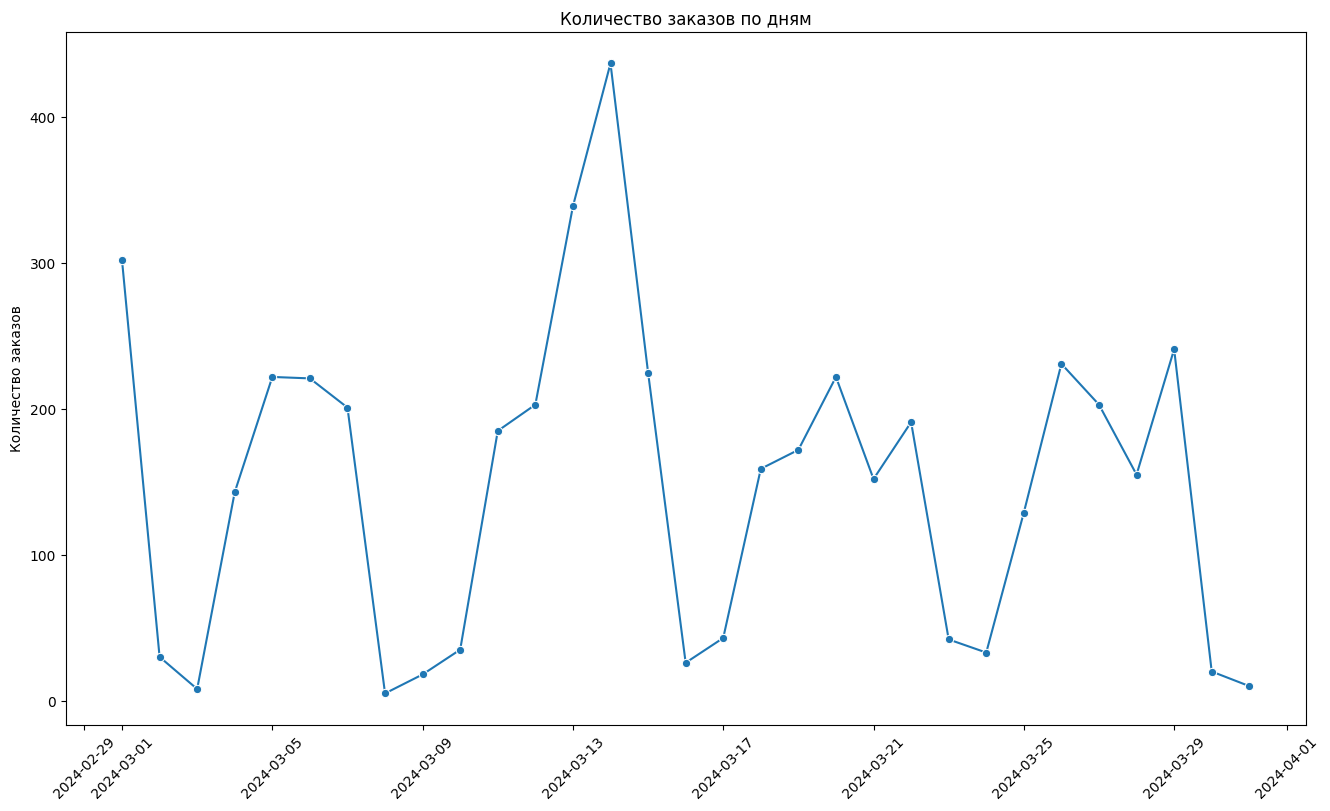

In [11]:
# Ваш код здесь
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 9))

sns.lineplot(data=df_top_dates_by_orders, x='date', y='orders_count', marker='o')

plt.title("Количество заказов по дням")
plt.ylabel("Количество заказов")
plt.xlabel("")
plt.xticks(rotation=45);



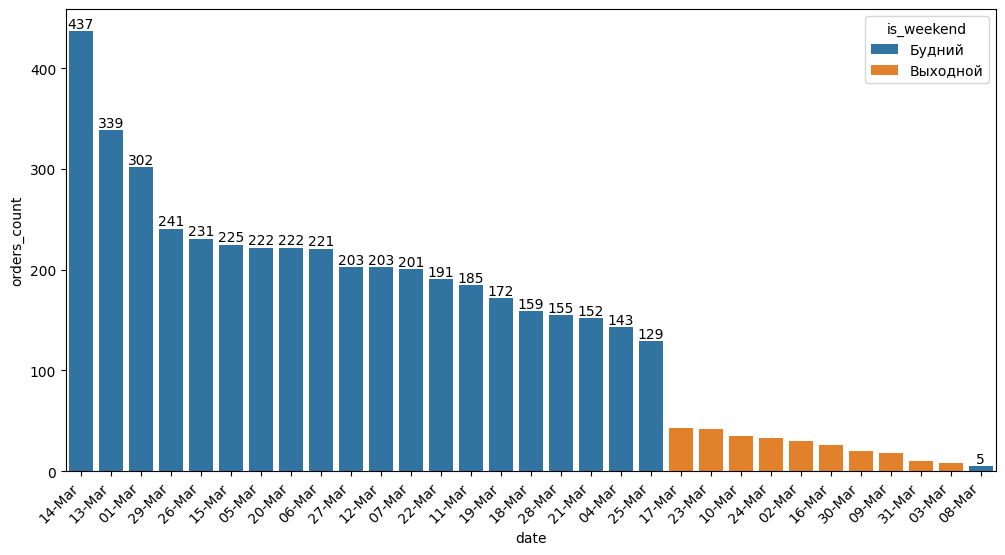

In [12]:
df_top_dates_by_orders['is_weekend'] = df_top_dates_by_orders['date'].dt.dayofweek >= 5
df_top_dates_by_orders['is_weekend'] = df_top_dates_by_orders['is_weekend'].map({True: 'Выходной', False: 'Будний'})


plt.figure(figsize=(12, 6))

ax1 = sns.barplot(
    data=df_top_dates_by_orders,
    x='date',
    y='orders_count',
    hue='is_weekend',
)
ax1.bar_label(ax1.containers[0])

# Изменим подписи у дат
date_labels = df_top_dates_by_orders['date'].dt.strftime("%d-%b") # %b - сокр. название месяца
ax1.set_xticks(range(len(date_labels))) # задаем диапазон дат
ax1.set_xticklabels(date_labels, rotation=45, ha="right") # размещаем новую версию дат

plt.show()

Вывод: В данных заметна сезонность, по выходным почти нет заказов

## Шаг 5

**Кажется, в данных помимо дня с наибольшим числом заказов есть еще один день, который выбивается из общей картины.** Что это за день:  
- Это воскресенье, в которое было много заказов?  
- Это понедельник, в который было много заказов?  
- Это пятница, в которую было мало заказов?  
- Это праздничный день, в который было мало заказов?

Укажите этот день в том формате, в котором он представлен в данных (гггг-мм-дд)

Ответ: 2024-03-08

8 марта - будний день, но праздничный и нерабочий, поэтому заказов было мало

## Шаг 6

К вам пришел радостный руководитель отдела продаж и попросил выяснить причину, почему заказы в один из дней резко подскочили, чтобы и дальше увеличивать продажи.

Возможно, в день с наибольшим числом заказов (который вы определили на третьем шаге) отдел маркетинга запустил какую-то акцию? Или менеджеры стали активнее предлагать компаниям оформить заказ? Нужно подробнее изучить этот день. Начнем со статусов заказа.

**Добавьте к данным о заказах информацию об их статусах. Общий датафрейм назовите `orders_status`. Сохраните получившийся датафрейм в csv файл `orders_status.csv` (при сохранении используйте параметр `index=False`) и отправьте этот csv файл на проверку в LMS.**

In [13]:
# Ваш код здесь
orders_status = pd.merge(df_orders, df_order_status, on='order_id')


In [14]:
orders_status.head()

,order_id,product_id,quantity,manager,date,client_id,status
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01,14,confirmed
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01,14,confirmed
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01,14,confirmed
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01,14,confirmed
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01,14,confirmed


In [15]:
orders_status.to_csv('orders_status.csv', index=False)

## Шаг 7

Посмотрите на количество и соотношение подтвержденных и отмененных заказов. **В ответе укажите долю отмененных заказов.** Ответ округлите до двух знаков после точки.

In [16]:
orders_status.status.value_counts()

status
confirmed    4083
canceled      520
Name: count, dtype: int64

In [17]:
total = len(orders_status.status)
canceled = (orders_status.status == 'canceled').sum()

share_canceled = canceled / total

print(f"Доля отмененных заказов: {share_canceled:.2f}")

Доля отмененных заказов: 0.11


## Шаг 8

**Посчитайте количество подтвержденных и отмененных заказов на каждую дату.** Определите, в какой день не было ни одного подтвержденного заказа. Для этого сделайте сводную таблицу, где в строках будут даты, в колонках — стутасы заказов, а значения — число заказов с этим статусом в определенную дату. Пропуски заполните нулями.  

**В ответ укажите день, когда не было ни одного подтвержденного заказа.** Дату укажите в том формате, в котором она представлена в данных (гггг-мм-дд).

In [18]:
orders_status.head()

,order_id,product_id,quantity,manager,date,client_id,status
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01,14,confirmed
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01,14,confirmed
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01,14,confirmed
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01,14,confirmed
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01,14,confirmed


In [19]:
# Ваш код здесь
orders_by_day_status = orders_status.groupby(['date', 'status'], as_index=False) \
            .agg(qnt=('product_id', 'count')) \
            .pivot(index='date', columns='status', values='qnt') \
            .fillna(0)
            

In [20]:
dates_only = [d.strftime('%Y-%m-%d') for d in orders_by_day_status.query('confirmed == 0').index]
print(*dates_only)

2024-03-09


## Шаг 9

**Постройте график с заказами по дням в разбивке по статусу заказа.** Посмотрим подробнее на день с наибольшим числом заказов (вместе и подтвержденных, и отменных), который мы определили ранее, и на день, предшествующий ему. Какой вывод можно сделать? Выберите один или несколько вариантов:

- В день с наибольшим числом заказов было очень много отмен  
- В день с наибольшим числом заказов было много успешно оформленных заказов  
- В день, предшествующий дню с наибольшим числом заказов, было много отмен  
- В день, предшествующий дню с наибольшим числом заказов, было много успешно оформленных заказов  
- В день, предшествующий дню с наибольшим числом заказов, не было ни одного успешно оформленного заказа  
- В день, предшествующий дню с наибольшим числом заказов, не было ни одного отмененного заказа

In [21]:
orders_by_day_status.head(10)

status,canceled,confirmed
date,,
2024-03-01,29.0,273.0
2024-03-02,0.0,30.0
2024-03-03,0.0,8.0
2024-03-04,0.0,143.0
2024-03-05,0.0,222.0
2024-03-06,12.0,209.0
2024-03-07,5.0,196.0
2024-03-08,0.0,5.0
2024-03-09,18.0,0.0


In [22]:
orders_by_day_status['total_orders'] = orders_by_day_status.sum(axis=1)

In [23]:
orders_by_day_status.head(10)

status,canceled,confirmed,total_orders
date,,,
2024-03-01,29.0,273.0,302.0
2024-03-02,0.0,30.0,30.0
2024-03-03,0.0,8.0,8.0
2024-03-04,0.0,143.0,143.0
2024-03-05,0.0,222.0,222.0
2024-03-06,12.0,209.0,221.0
2024-03-07,5.0,196.0,201.0
2024-03-08,0.0,5.0,5.0
2024-03-09,18.0,0.0,18.0


In [24]:
orders_by_day_status.index = orders_by_day_status.index.strftime('%Y-%m-%d')


In [25]:
orders_by_day_status.sort_values('total_orders', ascending=False).head(5)

status,canceled,confirmed,total_orders
date,,,
2024-03-14,0.0,437.0,437.0
2024-03-13,263.0,76.0,339.0
2024-03-01,29.0,273.0,302.0
2024-03-29,0.0,241.0,241.0
2024-03-26,14.0,217.0,231.0


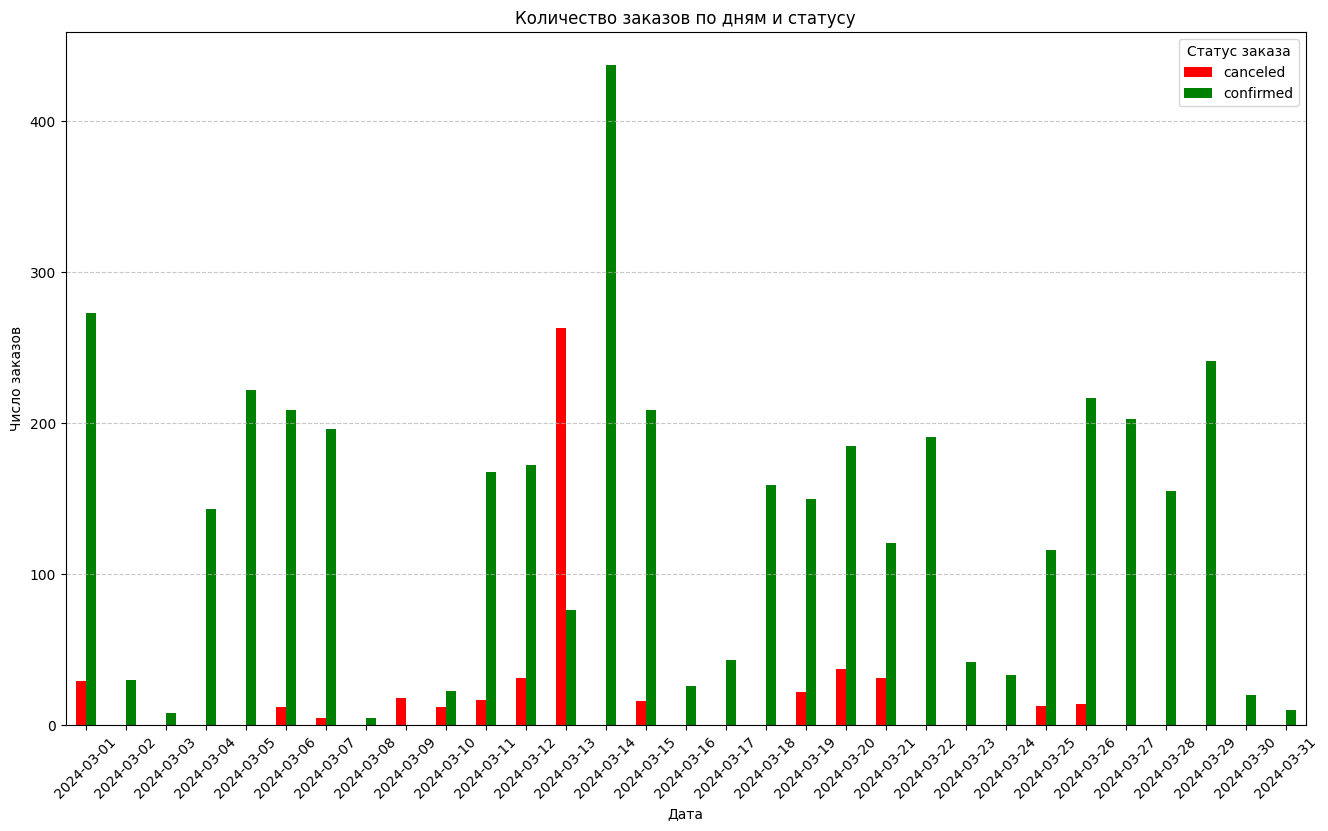

In [26]:
orders_by_day_status[['canceled', 'confirmed']].plot(
    kind='bar',
    figsize=(16,9),
    color=['red', 'green']
)

plt.title('Количество заказов по дням и статусу')
plt.ylabel('Число заказов')
plt.xlabel('Дата') 
plt.xticks(rotation=45)
plt.legend(title='Статус заказа') 
plt.grid(axis='y', linestyle='--', alpha=0.7)  # горизонтальная сетка

plt.show()

## Шаг 10

Рассмотрим эти два дня отдельно (день с наибольшим числом заказов, который мы определили ранее, и день, предшествующий ему). Проанализируйте заказы за эти дни и ответьте, какую из этих гипотез можно назвать наиболее правдоподобной.

- Так сложилось, что один день оказался крайне неудачным для отдела продаж, все клиенты отменили свои заказы. А на следующий день отдел продаж пытался компенсировать отсутствие продаж в предыдущий и перевыполнил дневной план. Почти все заказы не повторяют вчерашние  
- Произошел сбой в работе CRM системы, который не позволил клиентам подтвердить заказ. В результате все созданные в первый день заказы автоматически отменились, поэтому клиентам пришлось оформлять их повторно на следующий день. Почти половина заказов повторяет вчерашние


Шаги для решения:      
1) Отберем все отмененные заказы 13 марта и для каждого заказа агрегируем данные: посчитаем количество уникальных товаров в нем, сумму единиц всех товаров, а также возьмем менеджера и клиента.
      
2) Отберем все подтвержденные заказы 14 марта и для каждого заказа агрегируем данные: посчитаем количество уникальных товаров в нем, сумму единиц всех товаров, а также возьмем менеджера и клиента.
      
3) Объединим эти датафреймы с заказами по совпадающим характеристикам: имя менеджера, id клиента, число уникальных товаров в заказе и общее число товаров в штуках. Так у нас получатся те заказы, которые отменили в первый день и оформили заново на следующий.
      
4) Посчитайем число строк в датафрейме с заказами, которые отменили в первый день и оформили заново на следующий. Разделим это число на число строк в датафрейме с подтвержденными заказами 14 марта. Так мы узнаете долю заказов, которые повторяют вчерашние.
      


In [27]:
orders_status.head()

,order_id,product_id,quantity,manager,date,client_id,status
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01,14,confirmed
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01,14,confirmed
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01,14,confirmed
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01,14,confirmed
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01,14,confirmed


In [28]:
print(orders_status['status'].unique())

['confirmed' 'canceled']


### 1) Отмененные заказы 13 марта

In [29]:
canceled_orders_03_13 = orders_status.query('status == "canceled" and date == "2024-03-13"')

C:\Users\vesbe\AppData\Local\Temp\ipykernel_18968\2772215377.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  canceled_orders_03_13 = orders_status.query('status == "canceled" and date == "2024-03-13"')


In [30]:
orders_status.query('status == "canceled" and date == "2024-03-13"')

C:\Users\vesbe\AppData\Local\Temp\ipykernel_18968\1042694772.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  orders_status.query('status == "canceled" and date == "2024-03-13"')


,order_id,product_id,quantity,manager,date,client_id,status
1573,AFIH-00611801,511,13,Алексей Саксофонов,2024-03-13,43,canceled
1574,AFIH-00611801,240,21,Алексей Саксофонов,2024-03-13,43,canceled
1575,AFIH-00611801,583,8,Алексей Саксофонов,2024-03-13,43,canceled
1576,AFIH-00611801,468,5,Алексей Саксофонов,2024-03-13,43,canceled
1577,AFIH-00611801,648,16,Алексей Саксофонов,2024-03-13,43,canceled
...,...,...,...,...,...,...,...
1907,UUZR-48309816,1676,14,Маргарита Камертонова,2024-03-13,26,canceled
1908,UUZR-48309816,421,36,Маргарита Камертонова,2024-03-13,26,canceled
1909,UUZR-48309816,118,18,Маргарита Камертонова,2024-03-13,26,canceled
1910,UUZR-48309816,804,21,Маргарита Камертонова,2024-03-13,26,canceled


In [31]:


canceled_agg_03_13 = canceled_orders_03_13.groupby('order_id', as_index=False) \
        .agg({
            'product_id': 'nunique',
            'quantity': 'sum',
            'manager': 'max',
            'client_id': 'max'
        })

In [32]:
canceled_agg_03_13.head()

,order_id,product_id,quantity,manager,client_id
0,AFIH-00611801,11,192,Алексей Саксофонов,43
1,BBFJ-27674101,14,294,Ксения Балалайкина,73
2,CLBQ-63032648,13,205,Виктор Тромбонов,60
3,CYJY-07359557,13,316,Екатерина Тарелкина,56
4,GHGB-88045656,4,42,Ксения Балалайкина,7


### 2) Подтвержденные заказы 14 марта

In [33]:
confirmed_orders_03_14 = orders_status[
    (orders_status['date'] == '2024-03-14') & 
    (orders_status['status'] == 'confirmed')
]


In [34]:
confirmed_orders_03_14

,order_id,product_id,quantity,manager,date,client_id,status
1912,FDEB-71487438,511,13,Алексей Саксофонов,2024-03-14,43,confirmed
1913,FDEB-71487438,240,21,Алексей Саксофонов,2024-03-14,43,confirmed
1914,FDEB-71487438,583,8,Алексей Саксофонов,2024-03-14,43,confirmed
1915,FDEB-71487438,468,5,Алексей Саксофонов,2024-03-14,43,confirmed
1916,FDEB-71487438,648,16,Алексей Саксофонов,2024-03-14,43,confirmed
...,...,...,...,...,...,...,...
2344,DMEB-71700015,756,42,Сергей Контрабасов,2024-03-14,93,confirmed
2345,DMEB-71700015,525,2,Сергей Контрабасов,2024-03-14,93,confirmed
2346,DMEB-71700015,590,22,Сергей Контрабасов,2024-03-14,93,confirmed
2347,DMEB-71700015,1260,11,Сергей Контрабасов,2024-03-14,93,confirmed


In [35]:
confirmed_agg_03_14 = confirmed_orders_03_14.groupby('order_id', as_index=False) \
        .agg({
            'product_id': 'nunique',
            'quantity': 'sum',
            'manager': 'max',
            'client_id': 'max'
        })

In [36]:
confirmed_agg_03_14.head()

,order_id,product_id,quantity,manager,client_id
0,ACXS-56511429,8,177,Алексей Саксофонов,24
1,AUZX-12706022,19,369,Екатерина Тарелкина,83
2,BCMM-97072924,17,325,Алексей Саксофонов,51
3,BGHE-44722549,8,149,Виктор Тромбонов,95
4,DMEB-71700015,12,190,Сергей Контрабасов,93


### 3) Объединение по совпадающим характеристикам

In [37]:
merged_can13_con14 = pd.merge(canceled_agg_03_13, confirmed_agg_03_14,
                               on=['manager', 'client_id', 'product_id', 'quantity'],
                               suffixes=('_cancelled', '_confirmed'))

In [38]:
merged_can13_con14

,order_id_cancelled,product_id,quantity,manager,client_id,order_id_confirmed
0,AFIH-00611801,11,192,Алексей Саксофонов,43,FDEB-71487438
1,BBFJ-27674101,14,294,Ксения Балалайкина,73,UETB-44283966
2,CLBQ-63032648,13,205,Виктор Тромбонов,60,IECD-18739530
3,CYJY-07359557,13,316,Екатерина Тарелкина,56,WNMY-98871151
4,GHGB-88045656,4,42,Ксения Балалайкина,7,JUGG-73806170
5,JEIF-69283221,15,207,Виктор Тромбонов,94,EPBF-14743479
6,JQQO-28609300,15,252,Виктор Тромбонов,93,OWZC-14247946
7,KJJS-03491897,18,399,Алексей Саксофонов,66,GRCH-73394464
8,MIGZ-68487439,17,325,Алексей Саксофонов,51,BCMM-97072924
9,NBIO-35476164,14,319,Виктор Тромбонов,95,NFML-87752700


### 4) Расчет доли повторных заказов

In [39]:
repeated_orders_count = len(merged_can13_con14)
confirmed_orders_count = len(confirmed_agg_03_14)

repeated_ratio = repeated_orders_count / confirmed_orders_count

print(f"Число повторных заказов: {repeated_orders_count}")
print(f"Общее число подтвержденных заказов 14 марта: {confirmed_orders_count}")
print(f"Доля заказов, повторяющих вчерашние: {repeated_ratio:.2%}")


Число повторных заказов: 16
Общее число подтвержденных заказов 14 марта: 34
Доля заказов, повторяющих вчерашние: 47.06%


Вывод:
Наиболее правдоподобной выглядит вторая гипотеза — сбой CRM, потому что почти половина заказов повторяет вчерашние, что соответствует реальному сценарию с автоматической отменой и повторным оформлением

### Посчитаем ключевые метрики, посмотрим на их динамику и составим небольшой отчет

## Шаг 11

**У вас есть данные за целый месяц, поэтому пора посчитать ключевые метрики этого месяца.** Но вот незадача - в ваших данных цена единицы товара указана в долларах США, потому что закупаете их в долларах, но продаете товары за российские рубли (по тому курсу, который установил Центробанк на дату продажи), а значит и метрики требуется посчитать в рублях. Хорошо, что у вас есть текстовый файл с курсом доллара США на каждую дату. **Откройте файл `usd_rate.txt`, соберите из него датафрейм с 2 колонками: `date` и `currency_rate`. Посчитайте среднее значение курса доллара за месяц.** Результат округлите до двух знаков после точки.

In [40]:
# Ваш код здесь
with open('usd_rate.txt', 'r') as file:
    currency = file.readlines()

currency[:5]


['2024-03-01,90.8423,Доллар США\n',
 '2024-03-02,91.3336,Доллар США\n',
 '2024-03-03,91.3336,Доллар США\n',
 '2024-03-04,91.3336,Доллар США\n',
 '2024-03-05,91.3534,Доллар США\n']

In [41]:


dates = []
rates = []
for line in currency:
    line = line.strip()
    parts = line.split(',')

    dates.append(parts[0])
    rates.append(parts[1])

df_currency = pd.DataFrame({
    'date': dates,
    'currency_rate': rates
})

df_currency.head()

,date,currency_rate
0,2024-03-01,90.8423
1,2024-03-02,91.3336
2,2024-03-03,91.3336
3,2024-03-04,91.3336
4,2024-03-05,91.3534


In [42]:
df_currency.dtypes

date             object
currency_rate    object
dtype: object

In [43]:
df_currency['date'] = pd.to_datetime(df_currency['date'])
df_currency['currency_rate'] = df_currency['currency_rate'].astype(float)

In [44]:
df_currency.dtypes

date             datetime64[ns]
currency_rate           float64
dtype: object

In [45]:
round(df_currency.currency_rate.mean(), 2)

np.float64(91.7)

## Шаг 12

**Работу с ключевыми метриками начните с подсчета общей выручки.** Данные по товарам в подтвержденных заказах у вас есть в датафрейме `orders_status`, а стоимость одной единицы товара можно взять из датафрейма `df_products`. Объедините эти датафреймы в общий `df_full`, добавьте к ним информацию по курсу доллара на каждую дату. Создайте колонку с выручкой для каждого товара в заказах и посчитайте, **чему равна общая выручка в рублях?** Учитывайте только подтвержденные заказы. Результат округлите до двух знаков после точки.

In [46]:
df_full = pd.merge(orders_status, df_products, left_on='product_id', right_on='id')
df_full = pd.merge(df_full, df_currency, on='date')


In [47]:
df_full.head()

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01,14,confirmed,933,"Magnat, MC 400",430.56,Система караоке,90.8423
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01,14,confirmed,1645,"Yamaha, HPH-50B",41.78,Проводные наушники,90.8423
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01,14,confirmed,1596,"Yamaha, YH-E700A",304.02,Беспроводные наушники,90.8423
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01,14,confirmed,648,"JBL, Arena 125C",217.75,Центральный канал,90.8423
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01,14,confirmed,1413,"Singtrix, Home Karaoke System",315.88,Система караоке,90.8423


In [48]:
df_full['price_rub'] = df_full['currency_rate'] * df_full['price']

In [49]:
df_full.head()

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,price_rub
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01,14,confirmed,933,"Magnat, MC 400",430.56,Система караоке,90.8423,39113.060688
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01,14,confirmed,1645,"Yamaha, HPH-50B",41.78,Проводные наушники,90.8423,3795.391294
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01,14,confirmed,1596,"Yamaha, YH-E700A",304.02,Беспроводные наушники,90.8423,27617.876046
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01,14,confirmed,648,"JBL, Arena 125C",217.75,Центральный канал,90.8423,19780.910825
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01,14,confirmed,1413,"Singtrix, Home Karaoke System",315.88,Система караоке,90.8423,28695.265724


In [50]:
df_full['revenue'] = df_full['price_rub'] * df_full['quantity']

In [51]:
df_full

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,price_rub,revenue
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01,14,confirmed,933,"Magnat, MC 400",430.56,Система караоке,90.8423,39113.060688,2.737914e+05
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01,14,confirmed,1645,"Yamaha, HPH-50B",41.78,Проводные наушники,90.8423,3795.391294,1.366341e+05
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01,14,confirmed,1596,"Yamaha, YH-E700A",304.02,Беспроводные наушники,90.8423,27617.876046,1.104715e+06
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01,14,confirmed,648,"JBL, Arena 125C",217.75,Центральный канал,90.8423,19780.910825,1.978091e+05
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01,14,confirmed,1413,"Singtrix, Home Karaoke System",315.88,Система караоке,90.8423,28695.265724,1.721716e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4598,OYBY-86181208,1575,3,Анастасия Дудкина,2024-03-31,11,confirmed,1575,"Yamaha, RX-A3080",1935.70,AV-ресивер,92.3660,178792.866200,5.363786e+05
4599,OYBY-86181208,941,11,Анастасия Дудкина,2024-03-31,11,confirmed,941,"Magnat, Monitor Supreme Center 200",87.27,Центральный канал,92.3660,8060.780820,8.866859e+04
4600,OYBY-86181208,1335,22,Анастасия Дудкина,2024-03-31,11,confirmed,1335,"Sennheiser, e 835",85.56,Динамический микрофон,92.3660,7902.834960,1.738624e+05
4601,OYBY-86181208,296,22,Анастасия Дудкина,2024-03-31,11,confirmed,296,"Edifier, K800",36.08,Наушники с микрофоном,92.3660,3332.565280,7.331644e+04


In [52]:
df_confirmed = df_full.query('status == "confirmed"').copy()

In [53]:
total_revenue = df_confirmed['revenue'].sum()

In [54]:
f"Общая выручка: {round(total_revenue, 2):_} руб."

'Общая выручка: 2_038_231_821.56 руб.'

## Шаг 13

**Следующая метрика, которую вам нужно посчитать — средний чек в этом месяце (в рублях).** Разделите общую выручку на количество заказов. Результат округлите до двух знаков после точки.

<details>
<summary>&#9658; Нажмите сюда, чтобы увидеть подсказку</summary>
  <p>
      
1) Посчитайте число уникальных подтвержденных заказов.

2) Разделите сумму выручки, посчитанную на прошлом шаге (без округления), на это число.

3) Результат округлите до двух знаков после точки.  
      
</p>
</details>

In [55]:
unique_confirmed_orders = df_confirmed['order_id'].nunique()
avg_check = total_revenue / unique_confirmed_orders

print(round(avg_check, 2))

6596219.49


## Шаг 14

Ключевые метрики месяца вы посчитали, теперь попробуйте посмотреть на их динамику внутри месяца: посчитайте выручку, средний чек и число заказов — на каждый день. Посмотрите на графики и выберите верные ответы:

- число заказов и выручка каждый день изменяются в одинаковом направлении (если в этот день число заказов выросло, то и выручка выросла; число заказов упало — в этот же день упала и выручка)  
- число заказов и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день число заказов выросло, то выручка может упасть, и наоборот: число заказов упало — в этот же день выручка выросла)  
- средний чек и выручка каждый день изменяются в одинаковом направлении (если в этот день средний чек вырос, то и выручка выросла; средний чек упал — в этот же день упала и выручка)  
- средний чек и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день средний чек вырос, то выручка может упасть, и наоборот: средний чек упал — в этот же день выручка выросла)  
- в день с наибольшим числом заказов и выручка, и средний чек также показывают максимальное значение  
- в день с наибольшим числом заказов выручка и/или средний чек не показывают максимальное значение  
- с течением времени выручка то увеличивается, то уменьшается  
- с течением времени выручка только увеличивается  
- на протяжении всего месяца средний чек то увеличивается, то уменьшается  
- средний чек на протяжении всего месяца имеет одинаковое значение

In [56]:
df_report_by_date = df_confirmed.groupby('date', as_index=False).agg(
    revenue=('revenue', 'sum'),
    orders=('order_id', 'count')
)

df_report_by_date['avg_check'] = (df_report_by_date['revenue'] / df_report_by_date['orders']).round(2)

In [57]:
df_report_by_date.head()

,date,revenue,orders,avg_check
0,2024-03-01,1.554118e+08,273,569273.83
1,2024-03-02,1.197167e+07,30,399055.62
2,2024-03-03,2.548418e+06,8,318552.30
3,2024-03-04,6.404993e+07,143,447901.58
4,2024-03-05,8.952724e+07,222,403275.85


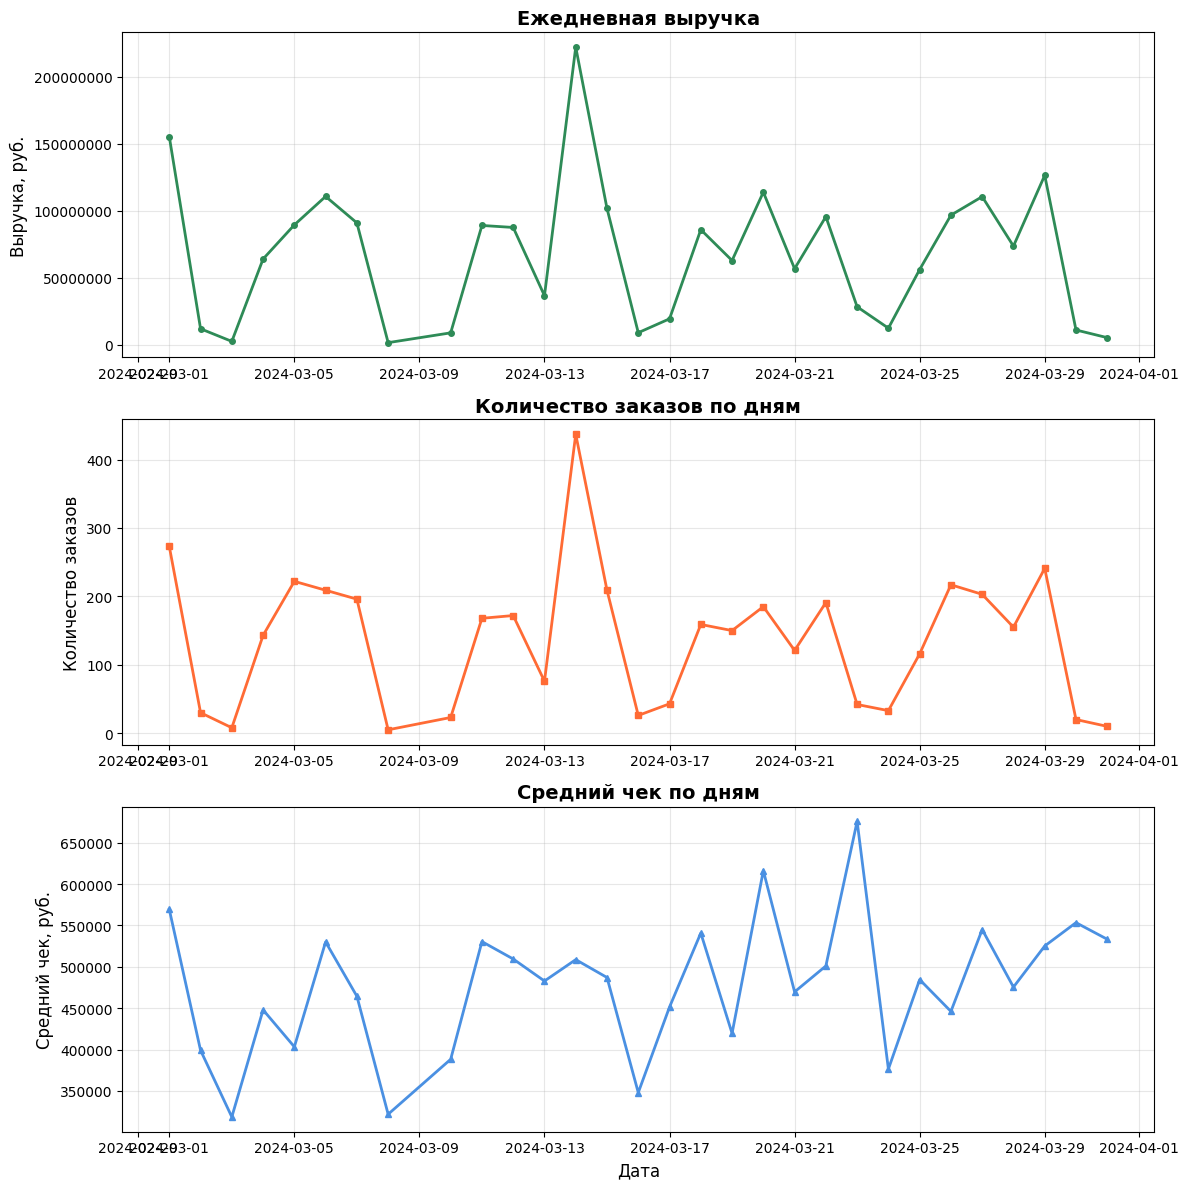

In [58]:
# Настройка стиля графиков
plt.style.use('default')
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# График 1: Выручка по дням
axes[0].plot(df_report_by_date['date'], df_report_by_date['revenue'], 
             marker='o', linewidth=2, markersize=4, color='#2E8B57')
axes[0].set_title('Ежедневная выручка', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Выручка, руб.', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(style='plain', axis='y')  # убираем научную нотацию

# График 2: Количество заказов по дням
axes[1].plot(df_report_by_date['date'], df_report_by_date['orders'], 
             marker='s', linewidth=2, markersize=4, color='#FF6B35')
axes[1].set_title('Количество заказов по дням', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Количество заказов', fontsize=12)
axes[1].grid(True, alpha=0.3)

# График 3: Средний чек по дням
axes[2].plot(df_report_by_date['date'], df_report_by_date['avg_check'], 
             marker='^', linewidth=2, markersize=4, color='#4A90E2')
axes[2].set_title('Средний чек по дням', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Средний чек, руб.', fontsize=12)
axes[2].set_xlabel('Дата', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Вывод:

    ✅ Число заказов и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день число заказов выросло, то выручка может упасть, и наоборот: число заказов упало — в этот же день выручка выросла)
    ✅ Средний чек и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день средний чек вырос, то выручка может упасть, и наоборот: средний чек упал — в этот же день выручка выросла)
    ✅ В день с наибольшим числом заказов выручка и/или средний чек не показывают максимальное значение
    ✅ С течением времени выручка то увеличивается, то уменьшается
    ✅ На протяжении всего месяца средний чек то увеличивается, то уменьшается

### Проанализируем интерес клиентов к брендам

## Шаг 15

К вам снова обратился руководитель отдела продаж. Он хочет разобраться, какие бренды востребованы среди клиентов, а какие — нет. На основе данных о названиях товаров в датафрейме `df_full` создайте новую колонку `brand`, где будет только название бренда. **Посчитайте, сколькими брендами интересовались клиенты** (статус заказа здесь не важен, если запись о бренде попала в данные о заказах, значит клиент заказал или хотел заказать товар этого бренда).

<details>
<summary>&#9658; Нажмите сюда, чтобы увидеть подсказку</summary>
  <p>
      
1) В датафрейме `df_full` создайте новую колонку `brand`, в которую поместите только названия брендов. Для этого разделите значения в колонке name и возьмите первое из них (сначала идет бренд и через запятую модель товара).

2) Посчитайте количество уникальных значений в колонке `brand`.
      
</p>
</details>

In [59]:
df_full['brand'] = df_full.name.apply(lambda x: x.split(',')[0])

In [60]:
df_full.head()

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,price_rub,revenue,brand
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01,14,confirmed,933,"Magnat, MC 400",430.56,Система караоке,90.8423,39113.060688,2.737914e+05,Magnat
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01,14,confirmed,1645,"Yamaha, HPH-50B",41.78,Проводные наушники,90.8423,3795.391294,1.366341e+05,Yamaha
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01,14,confirmed,1596,"Yamaha, YH-E700A",304.02,Беспроводные наушники,90.8423,27617.876046,1.104715e+06,Yamaha
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01,14,confirmed,648,"JBL, Arena 125C",217.75,Центральный канал,90.8423,19780.910825,1.978091e+05,JBL
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01,14,confirmed,1413,"Singtrix, Home Karaoke System",315.88,Система караоке,90.8423,28695.265724,1.721716e+05,Singtrix


In [61]:
df_full.brand.nunique()

121

## Шаг 16

Посчитайте, какую выручку принес каждый бренд и в скольких подтвержденных заказах были товары этого бренда. **Определите, какой бренд принес наибольшую выручку.** В ответ укажите его название.

Дополнительно: проверьте, именно этот бренд встречается в большем количестве заказов, чем другие бренды? Или может его реже заказывают, но на более крупные суммы?

In [62]:
# Ваш код здесь
df_top_revenue_brands = df_full[df_full.status == 'confirmed'].groupby('brand', as_index=False) \
        .agg({'revenue': 'sum',
              'order_id': 'nunique'
              }).rename(columns={'order_id': 'unique_orrders'}) \
        .sort_values('revenue', ascending=False)


In [63]:
df_top_revenue_brands.head(10)

,brand,revenue,unique_orrders
46,JBL,2.665961e+08,264
43,Heco,2.388163e+08,229
53,Klipsch,2.039024e+08,205
120,Yamaha,1.658651e+08,218
49,KEF,1.465101e+08,73
62,Magnat,1.141989e+08,154
118,Wharfedale,1.129230e+08,127
42,Harman Kardon,1.035031e+08,125
82,Q-Acoustics,1.021578e+08,117
26,Dali,8.353668e+07,52


In [64]:
top_brand_revenue = df_top_revenue_brands.brand.iloc[0]
print(top_brand_revenue)

JBL


Доп. вопрос: Бренд "JBL" занимает первое место по выручке за счет кол-ва заказов, а не из-за заказов на большие суммы 

## Шаг 17

У одних брендов большинство товаров востребовано клиентами, а у других — клиенты заказывают только небольшую часть товаров, а остальные зря занимают виртуальную «полку» в перечне товаров, продаваемых вашей компанией. **Вам нужно определить, какие бренды редко попадают в заказы, хотя товаров таких брендов на самом деле много.**

Начнем с того, что определим, какие товары из имеющихся в продаже хоть раз заказывали, а какие — нет. Для этого соберите список из перечня уникальных идентификаторов товаров, которые встречаются в датафрейме `df_confirmed`. После этого для каждого товара в датафрейме `df_products` определите, был ли этот товар в списке заказанных товаров в этом месяце или нет: создайте новую колонку `is_in_orders` и заполните её соответственно значениями `yes` или `no` для каждого товара.

**В ответе укажите, сколько товаров были заказаны, а сколько — не были**

In [65]:
# Ваш код здесь
product_in_orders = df_confirmed.product_id.to_list()



In [66]:
df_products['is_in_orders'] = df_products['id']. \
        apply(lambda x: 'yes' if x in product_in_orders else 'no')

In [67]:
yes_count = (df_products['is_in_orders'] == 'yes').sum()
no_count = (df_products['is_in_orders'] == 'no').sum()

print(f"✅ Заказано: {yes_count} товаров")
print(f"❌ Не заказано: {no_count} товаров")
print(f"📊 Итого: {yes_count + no_count} товаров в каталоге")

✅ Заказано: 1180 товаров
❌ Не заказано: 497 товаров
📊 Итого: 1677 товаров в каталоге


## Шаг 18

Примерно треть товаров не была заказана ни разу в этом месяце. Посмотрим на эти данные в разрезе по брендам. **Определите, у каких брендов доля ни разу не заказанных товаров была больше половины от всех продаваемых товаров этого бренда.** Но не берите в расчет бренды, которые представлены маленьким числом товаров (меньше 15), они не захламляют виртуальную «полку».

Отметьте бренды, у которых доля ни разу не заказанных товаров была больше половины от всех продаваемых товаров этого бренда: 
- AKG  
- ASUS	
- Dali  
- Emotiva  
- KEF  
- Marantz  
- Onkyo  
- Pioneer  
- Yaqin

In [68]:
# Ваш код здесь
df_products['brand'] = df_products.name.apply(lambda x: x.split(',')[0])


In [69]:
brand_orders_analysis = df_products.groupby(['brand', 'is_in_orders'], as_index=False) \
        .agg({'id': 'nunique'}).rename(columns={'id': 'unique_products'})

In [70]:
brand_orders_pivot = brand_orders_analysis \
    .pivot(columns='is_in_orders', index='brand', values='unique_products')

In [71]:
brand_orders_pivot = brand_orders_pivot.fillna(0)
brand_orders_pivot = brand_orders_pivot.reset_index()

In [72]:
brand_orders_pivot['total_products'] = brand_orders_pivot['no'] + brand_orders_pivot['yes']
brand_orders_pivot['not_ordered_ratio'] = brand_orders_pivot['no'] / brand_orders_pivot['total_products']

problem_brands = brand_orders_pivot.query('not_ordered_ratio > 0.5 & total_products > 15') \
        .sort_values('not_ordered_ratio', ascending=False) \
        .brand.to_list()

In [73]:
print('''Бренды, у которых доля ни разу не заказанных товаров 
была больше половины от всех продаваемых товаров 
этого бренда:''', *problem_brands)

Бренды, у которых доля ни разу не заказанных товаров 
была больше половины от всех продаваемых товаров 
этого бренда: Marantz Dali Pioneer KEF


### Составим отчет по продажам менеджеров

## Шаг 19

Чтобы компания знала, кого из менеджеров отдела продаж премировать, а с кем провести беседу по итогам месяца, **вас попросили сделать отчет по сделкам каждого менеджера**: сколько он оформил подтвержденных заказов и какую выручку они принесли. Но в абсолютных числах вклад каждого сотрудника может быть непонятен. **Поэтому посчитайте значения в процентах: какой % выручки от общей выручки за месяц приходится на каждого менеджера, и какой % заказов от общего числа заказов.** Посчитайте данные и визуализируйте результат, чтобы принимать решение о поощрении или проведении беседы с менеджерами было удобнее. Выберите верные ответы:

- лучшим менеджером по % выручки стала Маргарита Камертонова  
- лучшим менеджером по % заказов стала Маргарита Камертонова  
- первая пятерка менеджеров по % выручки сильно ушла вперед от всех остальных (явно виден большой разрыв между каждым из первой пятерки и каждым из всех остальных менеджеров)  
- в этом месяце нельзя выделить явную пятерку лидеров по % выручки, которые сильно оторвались от остальных  
- лидер по % заказов реализовал более 16% заказов  
- лидер по % заказов реализовал менее 16% заказов  
- наихудшие показатели у Сергея Контрабасова  
- наихудшие показатели у Аркадия Октавина  
- Антон Скрипкин принес в 3 раза меньше выручки, чем Виктор Тромбонов  
- Антон Скрипкин реализовал почти в 3 раза меньше заказов, чем Анастасия Дудкина

In [74]:
df_confirmed.head()

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,price_rub,revenue
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01,14,confirmed,933,"Magnat, MC 400",430.56,Система караоке,90.8423,39113.060688,2.737914e+05
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01,14,confirmed,1645,"Yamaha, HPH-50B",41.78,Проводные наушники,90.8423,3795.391294,1.366341e+05
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01,14,confirmed,1596,"Yamaha, YH-E700A",304.02,Беспроводные наушники,90.8423,27617.876046,1.104715e+06
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01,14,confirmed,648,"JBL, Arena 125C",217.75,Центральный канал,90.8423,19780.910825,1.978091e+05
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01,14,confirmed,1413,"Singtrix, Home Karaoke System",315.88,Система караоке,90.8423,28695.265724,1.721716e+05


In [75]:
manager_performance = df_confirmed.groupby('manager', as_index=False) \
    .agg(
        sum_revenue=('revenue', 'sum'),
        orders=('order_id', 'nunique')
    ).sort_values('sum_revenue',ascending=False)


In [76]:
total_revenue = manager_performance['sum_revenue'].sum()
total_orders = manager_performance['orders'].sum()

manager_performance['revenue_pct'] = (manager_performance['sum_revenue'] / total_revenue * 100).round(2)
manager_performance['orders_pct'] = (manager_performance['orders'] / total_orders * 100).round(2)

manager_performance

,manager,sum_revenue,orders,revenue_pct,orders_pct
9,Маргарита Камертонова,3.473886e+08,48,17.04,15.53
4,Виктор Тромбонов,3.188999e+08,50,15.65,16.18
8,Максим Барабанов,2.401478e+08,40,11.78,12.94
5,Владимир Ударников,2.084865e+08,31,10.23,10.03
0,Алексей Саксофонов,1.953435e+08,27,9.58,8.74
7,Ксения Балалайкина,1.817621e+08,27,8.92,8.74
6,Екатерина Тарелкина,1.781576e+08,28,8.74,9.06
10,Надежда Гармошкина,1.347836e+08,21,6.61,6.80
1,Анастасия Дудкина,1.234504e+08,20,6.06,6.47
2,Антон Скрипкин,5.150268e+07,7,2.53,2.27


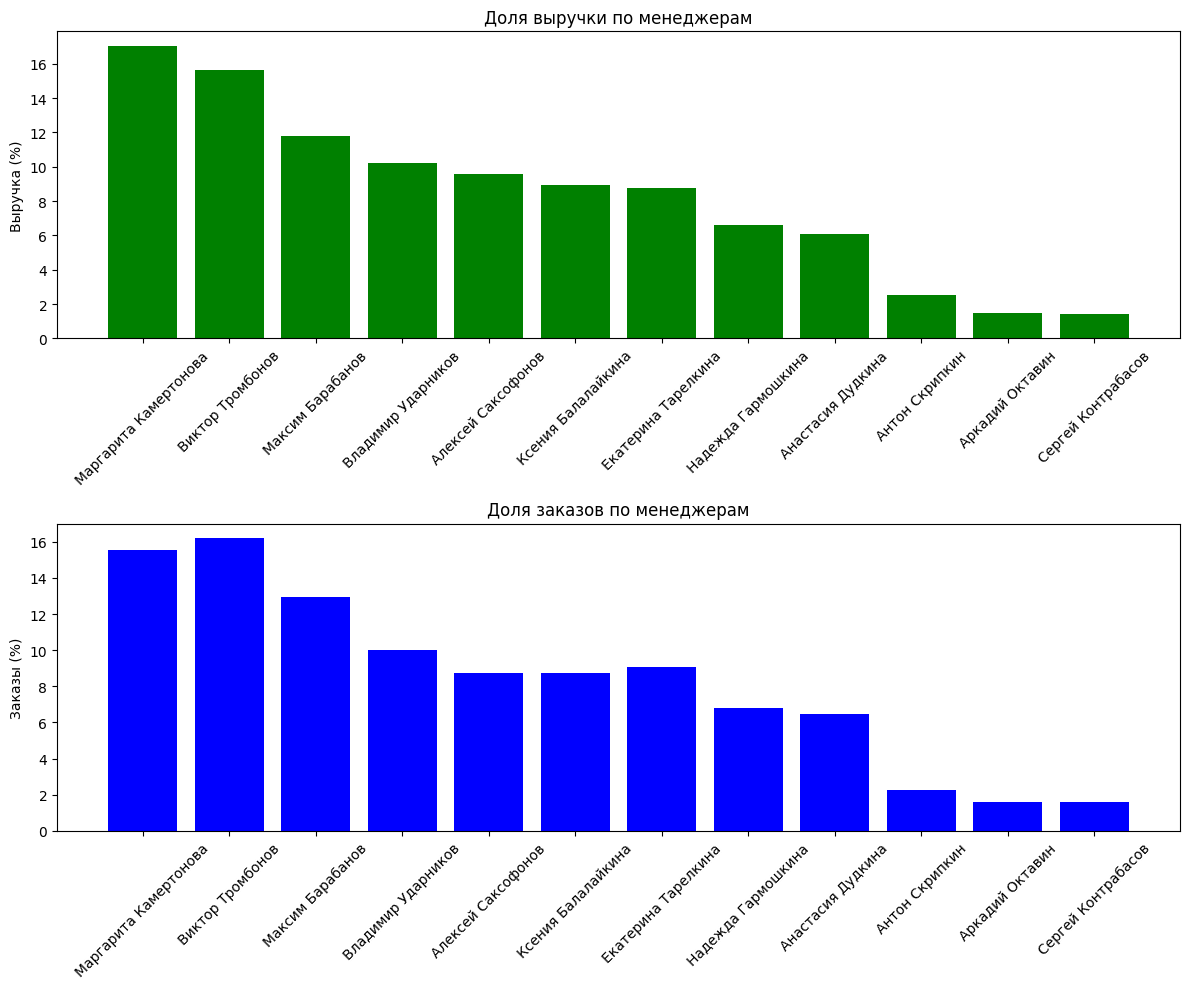

In [77]:
plt.figure(figsize=(12, 10))

# Первый график - выручка
plt.subplot(2, 1, 1)  # 2 строки, 1 колонка, первый график
plt.bar(manager_performance['manager'], manager_performance['revenue_pct'], color='green')
plt.title('Доля выручки по менеджерам')
plt.ylabel('Выручка (%)')
plt.xticks(rotation=45)
# Второй график - заказы
plt.subplot(2, 1, 2)  # 2 строки, 1 колонка, второй график
plt.bar(manager_performance['manager'], manager_performance['orders_pct'], color='blue')
plt.title('Доля заказов по менеджерам')
plt.ylabel('Заказы (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Выводы:

    ✅ Лучшим менеджером по % выручки стала Маргарита Камертонова
    ✅ В этом месяце нельзя выделить явную пятерку лидеров по % выручки, которые сильно оторвались от остальных
    ✅ Лидер по % заказов реализовал более 16% заказов
    ✅ Наихудшие показатели у Сергея Контрабасова
    ✅ Антон Скрипкин реализовал почти в 3 раза меньше заказов, чем Анастасия Дудкина
